<font color=#16A085>
    
# Python Analysis of the static FRET example data
Extract E and S information and make pretty plots.

</font>

Written by: Nadia M. Huisjes and Karl E. Duderstadt

In [47]:
# File paths and names
file_path_fiji = '/Applications/Fiji-mars.app'  #Path to your Fiji application
saved_archive_name = '/Users/karlduderstadt4/git/mars-tutorials/Example_workflows/FRET/static/1-lo_1-mid_merged.yama' #Name of your saved archive

In [48]:
# Import packages
import imagej
import jpype
import jpype.imports

# Set the path to the local Fiji application if it does not exist yet
try:
    ij
except NameError:
    ij = imagej.init(file_path_fiji) 
    
# Import the other packages
import scyjava as sc
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import math
from scyjava import jimport
File = jimport("java.io.File")
from de.mpg.biochem.mars.molecule import SingleMoleculeArchive
from scipy.stats import norm
from scipy.optimize import curve_fit
from matplotlib.gridspec import GridSpec

# Set up the connection to the archive
yamaFile = File(saved_archive_name) 
archive = SingleMoleculeArchive(yamaFile)

---

#### Define functions for data handling and plotting

In [49]:
def create_df(mol_tags):
    '''Create a df from all molecules in the archive that have all tags in the list provided'''
    #Create a map to all molecules in the archive
    molecules = map(lambda UID: archive.get(UID), archive.getMoleculeUIDs())
    
    rowsList = []
    for molecule in molecules:
        if not False in [molecule.hasTag(mol_tag) for mol_tag in mol_tags]:
            marsTable = archive.get(molecule.getUID()).getTable()
            for row in range(marsTable.getRowCount()):
                if math.isnan(marsTable.getValue('iiEapp', row)):
                    break
                rowDict = {}
                rowDict['iiEapp'] = marsTable.getValue('iiEapp', row)
                rowDict['iiSapp'] = marsTable.getValue('iiSapp', row)
                rowDict['iiiEapp'] = marsTable.getValue('iiiEapp', row)
                rowDict['iiiSapp'] = marsTable.getValue('iiiSapp', row)
                rowDict['E'] = marsTable.getValue('E', row)
                rowDict['S'] = marsTable.getValue('S', row)
                rowsList.append(rowDict)
                
    return pd.DataFrame(rowsList)

In [50]:
def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

In [51]:
def fit_ES(df, fit_col, bins, mu, sigma, A, show_model):
    ''''''
    y, bin_edges = np.histogram(df[fit_col], bins, range=(0, 1))
    x = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    expected=(mu, sigma, A)
    params,cov=curve_fit(gauss,x,y,expected)
    
    if (show_model == True):
        plot(x,gauss(x,*params),color='red',lw=3,label='model')
        legend()
    
    if (show_model == False):
        plt.close()
    
    return (params[0], params[1], params[2])

In [52]:
def corr_plot(df, alpha,x_low,x_high,y_low,y_high):
    '''Plots the progression of S vs E over the course of all corrections.'''
    fig,ax=plt.subplots(3,1, sharex=True, sharey=True, figsize=(4,15))
    ax[0].scatter(df['iiEapp'],df['iiSapp'],alpha=alpha)
    ax[1].scatter(df['iiiEapp'],df['iiiSapp'],alpha=alpha)
    ax[2].scatter(df['E'],df['S'],alpha=alpha)

    ax[0].set_xlim(x_low,x_high)
    ax[0].set_ylim(y_low,y_high)
    
    ax[0].set_xlabel("iiEapp")
    ax[1].set_xlabel("iiiEapp")
    ax[2].set_xlabel("E")
    
    ax[0].set_ylabel("iiSapp")
    ax[1].set_ylabel("iiiSapp")
    ax[2].set_ylabel("S")
    
    ax[0].set_title("Background corrected")
    ax[1].set_title("Background + alpha/delta corrected")
    ax[2].set_title("Fully corrected")

    plt.show()

In [53]:
def final_plot_fit(df_lo, df_mid, E, S, df_DO, df_AO, alpha_F, alpha, bins_S_lo, bins_S_mid, bins_E_lo, bins_E_mid,          
                   file_name, DPI):
    '''Makes the typical FRET plot showing an S vs. E scatter plot as well as the corresponding 
    histograms. The two populations (lo and mid) are displayed separately, AO and DO are displayed in different
    colors.'''
    
    #fit_ES(df, fit_col, bins, mu, sigma, A, show_model)
    
    E_lo_mu, E_lo_sigma, E_lo_A = fit_ES(df_lo, E, bins_E_lo, 0.2, 0.15, 200, False)
    S_lo_mu, S_lo_sigma, S_lo_A = fit_ES(df_lo, S, bins_S_lo, 0.5, 0.15, 200, False)
    E_mid_mu, E_mid_sigma, E_mid_A = fit_ES(df_mid, E, bins_E_mid, 0.6, 0.15, 200, False)
    S_mid_mu, S_mid_sigma, S_mid_A = fit_ES(df_mid, S, bins_S_mid, 0.5, 0.15, 200, False)
    
    x_list = list(np.arange(0,1,0.01))
    y_list_E_lo = gauss(x_list, E_lo_mu, E_lo_sigma, E_lo_A)
    y_list_S_lo = gauss(x_list, S_lo_mu, S_lo_sigma, S_lo_A)
    y_list_E_mid = gauss(x_list, E_mid_mu, E_mid_sigma, E_mid_A)
    y_list_S_mid = gauss(x_list, S_mid_mu, S_mid_sigma, S_mid_A)
    
    fig = plt.figure()
    gs = GridSpec(4, 4)
    ax_scatter = fig.add_subplot(gs[1:4, 0:3])
    ax_hist_y = fig.add_subplot(gs[0,0:3])
    ax_hist_x = fig.add_subplot(gs[1:4, 3])
    
    ax_scatter.scatter(df_lo[E],df_lo[S],color='#9D9D9C',alpha=alpha_F,label='1-lo')
    ax_scatter.scatter(df_mid[E],df_mid[S],color='#9D9D9C',alpha=alpha_F, label='1-mid')
    ax_scatter.scatter(df_DO[E],df_DO[S],color='#315BA5',alpha=alpha, label='DO')
    ax_scatter.scatter(df_AO[E],df_AO[S],color='#BD214D',alpha=alpha, label='AO')

    ax_scatter.set_xlim(0,1)
    ax_scatter.set_ylim(0,1)
    ax_scatter.set_xlabel("FRET efficiency")
    ax_scatter.set_ylabel("Stoichiometry")
    
    ax_hist_y.hist(df_lo[E],bins=bins_E_lo,color='#9D9D9C', range=(0, 1))
    ax_hist_y.hist(df_mid[E],bins=bins_E_mid,color='#9D9D9C', range=(0, 1))
    ax_hist_y.plot(x_list,y_list_E_lo,color='black')
    ax_hist_y.plot(x_list,y_list_E_mid,color='black')
    ax_hist_y.set_xlim(0,1)
    ax_hist_y.xaxis.set_visible(False)
    ax_hist_y.set_ylabel("Count")

    ax_hist_x.hist(df_lo[S],color='#9D9D9C',orientation = 'horizontal',bins=bins_S_lo, range=(0, 1))
    ax_hist_x.hist(df_mid[S],color='#9D9D9C',orientation = 'horizontal',bins=bins_S_mid, range=(0, 1))

    ax_hist_x.plot(y_list_S_mid,x_list,color='black')
    ax_hist_x.yaxis.set_visible(False)
    ax_hist_x.set_ylim(0,1)
    ax_hist_x.set_xlabel("Count")
    
    
    leg = ax_scatter.legend()
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    
    plt.savefig(file_name,dpi=DPI)
    plt.show()

#### Create the dataframes for all populations (lo, mid, AO, DO) from the archive

In [54]:
df_lo = create_df(["1-lo", "FRET", "Accepted"])
df_mid = create_df(["1-mid", "FRET", "Accepted"])
df_AO = create_df(["AO", "Accepted"])
df_DO = create_df(["DO", "Accepted"])

#### Plot the progression over each correction step

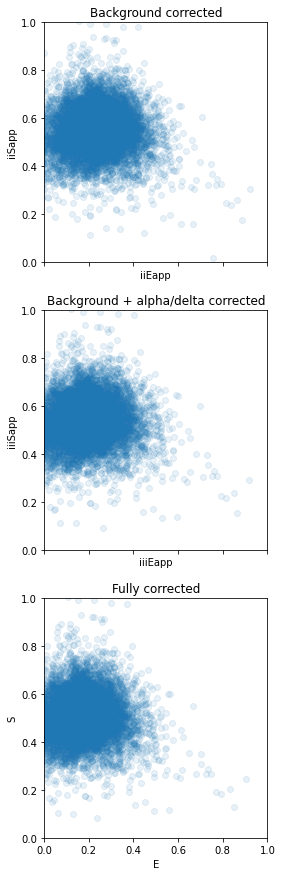

None

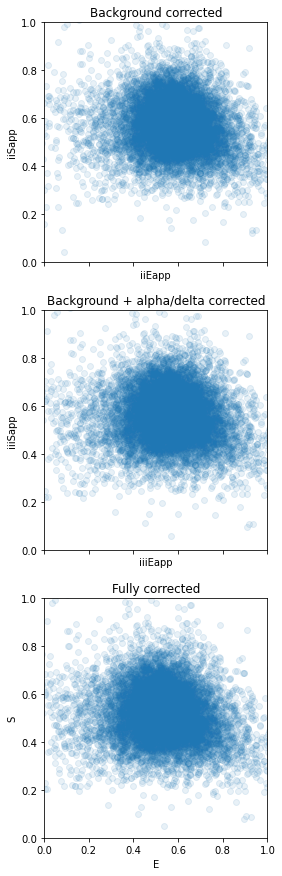

None

In [55]:
display(corr_plot(df_lo,0.1,0,1,0,1))
display(corr_plot(df_mid,0.1,0,1,0,1))

#### Find the Gaussian fit values and sigma values

In [56]:
E_lo, E_lo_sigma, E_lo_A = fit_ES(df_lo, "E", 1000, 0.2, 0.15, 200, False)
S_lo, S_lo_sigma, S_lo_A = fit_ES(df_lo, "S", 5000, 0.5, 0.15, 200, False)

E_mid, E_mid_sigma, E_mid_A = fit_ES(df_mid, "E", 10000, 0.6, 0.15, 200, False)
S_mid, S_mid_sigma, S_mid_A = fit_ES(df_mid, "S", 50000, 0.5, 0.15, 200, False)

S_AO, S_AO_sigma, S_AO_A = fit_ES(df_AO, "S", 1000, 0, 0.15, 200, False)

E_DO, E_DO_sigma, E_DO_A = fit_ES(df_DO, "E", 1000, 0, 0.15, 200, False)
S_DO, S_DO_sigma, S_DO_A = fit_ES(df_DO, "S", 1000, 1, 0.15, 200, False)

# Supply NaN values to all unknown parameters
E_AO, E_AO_sigma = (np.NaN, np.NaN)

# Display the fit results in a table 
Gaussian_dict = {'Sample Population':['lo','mid','AO','DO'],
                 'E' : [E_lo, E_mid, E_AO, E_DO], 'E_sigma' : [E_lo_sigma, E_mid_sigma, E_AO_sigma, E_DO_sigma],
                'S' : [S_lo, S_mid, S_AO, S_DO], 'S_sigma' : [S_lo_sigma, S_mid_sigma, S_AO_sigma, S_DO_sigma]}
df = pd.DataFrame(Gaussian_dict).set_index('Sample Population')
df

,E,E_sigma,S,S_sigma
Sample Population,,,,
lo,0.161752,0.106207,0.502261,0.092074
mid,0.530390,0.127764,0.516548,0.113101
AO,NaN,NaN,0.057023,0.125705
DO,-0.003239,0.109851,1.001552,0.094764


#### Make the final plot of the fully corrected E and S values in this archive

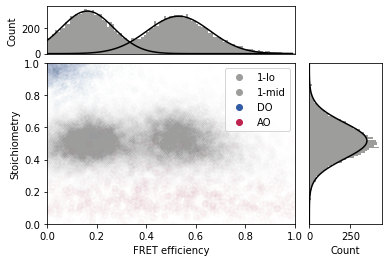

In [57]:
final_plot_fit(df_lo, df_mid, "E", "S", df_DO, df_AO, 0.005, 0.01, 100, 100, 100, 100, "Final_with_fits.png", 300)